 <div style="border-radius:10px; border:#4E5672 solid; padding: 15px; background-color: #C7B299; font-size:100%; text-align:left">
    <b> Description:</b>
    
This dataset contains detailed information about individual bank customers, capturing key attributes essential for understanding and predicting customer behavior. Focused on customers who have either terminated their relationship with the bank (churned) or those who remain active, the dataset provides insights into customer profiles. It encompasses crucial features such as credit score, geographical location, gender, age, tenure, account balance, usage of bank products, credit card ownership, active membership status, estimated salary, and the ultimate churn status.

In [1]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import optuna

<p style="background-color:#C7B299; font-family:'Courier New', monospace;  font-size:140%; text-align:center; padding: 10px; border-radius: 20px;"> <b>📖 Reading and Cleaning 🧹</b> </p>



### <p style="font-family:JetBrains Mono; font-weight:bold; letter-spacing: 2px; color:#C7B299; font-size:120%; text-align:left;padding: 0px; border-bottom: 3px solid #8B7D6B">Reading</p>

In [2]:
path = "/kaggle/input/playground-series-s4e1/"
train = pd.read_csv(path+"train.csv")
test = pd.read_csv(path+"test.csv")
sub = pd.read_csv(path+"sample_submission.csv")


In [3]:
train.drop(["id","Surname"],axis=1, inplace=True)
test.drop(["id","Surname"],axis=1, inplace=True)

In [4]:
train.head(10)

,CustomerId,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,15674932,668,France,Male,33.0,3,0.00,2,1.0,0.0,181449.97,0
1,15749177,627,France,Male,33.0,1,0.00,2,1.0,1.0,49503.50,0
2,15694510,678,France,Male,40.0,10,0.00,2,1.0,0.0,184866.69,0
3,15741417,581,France,Male,34.0,2,148882.54,1,1.0,1.0,84560.88,0
4,15766172,716,Spain,Male,33.0,5,0.00,2,1.0,1.0,15068.83,0
5,15771669,588,Germany,Male,36.0,4,131778.58,1,1.0,0.0,136024.31,1
6,15692819,593,France,Female,30.0,8,144772.69,1,1.0,0.0,29792.11,0
7,15669611,678,Spain,Male,37.0,1,138476.41,1,1.0,0.0,106851.60,0
8,15691707,676,France,Male,43.0,4,0.00,2,1.0,0.0,142917.13,0
9,15591721,583,Germany,Male,40.0,4,81274.33,1,1.0,1.0,170843.07,0


<div style="border-radius:10px; border:#4E5672 solid; padding: 15px; background-color: #C7B299; font-size:100%; text-align:left">
   <h3 align="left"><font > Features: </font></h3>

1. **Customer ID:** A unique identifier for each customer.
2. **Surname:** The customer's last name.
3. **Credit Score:** Numerical representation of creditworthiness.
4. **Geography:** Country of residence (France, Spain, Germany).
5. **Gender:** Customer's gender (Male or Female).
6. **Age:** Customer's age.
7. **Tenure:** Number of years with the bank.
8. **Balance:** Customer's account balance.
9. **NumOfProducts:** Number of bank products used.
10. **HasCrCard:** Presence of a credit card (1 = yes, 0 = no).
11. **IsActiveMember:** Active membership status (1 = yes, 0 = no).
12. **EstimatedSalary:** Estimated salary of the customer.
13. **Exited:** Churn status (1 = yes, 0 = no).

### <p style="font-family:JetBrains Mono; font-weight:bold; letter-spacing: 2px; color:#C7B299; font-size:120%; text-align:left;padding: 0px; border-bottom: 3px solid #8B7D6B">Cleaning</p>

In [5]:
train.isnull().sum()

CustomerId         0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

In [6]:
train.duplicated().sum()

30

In [7]:
train.drop_duplicates(inplace = True)

In [8]:
train.nunique()

CustomerId         23221
CreditScore          457
Geography              3
Gender                 2
Age                   71
Tenure                11
Balance            30075
NumOfProducts          4
HasCrCard              2
IsActiveMember         2
EstimatedSalary    55298
Exited                 2
dtype: int64

In [9]:
num_cols = [col for col in train.columns if (train[col].dtype in ["int64","float64"]) & (train[col].nunique()>4)]
num_cols

['CustomerId', 'CreditScore', 'Age', 'Tenure', 'Balance', 'EstimatedSalary']

In [10]:
cat_cols = [col for col in train.columns if (train[col].nunique() <= 4) and (col != 'Exited')]
cat_cols

['Geography', 'Gender', 'NumOfProducts', 'HasCrCard', 'IsActiveMember']

<p style="background-color:#C7B299; font-family:'Courier New', monospace;  font-size:140%; text-align:center; padding: 10px; border-radius: 20px;"> <b>📊 Exploratory Data Analysis (EDA) 📊</b> </p>


### <p style="font-family:JetBrains Mono; font-weight:bold; letter-spacing: 2px; color:#C7B299; font-size:120%; text-align:left;padding: 0px; border-bottom: 3px solid #8B7D6B">Target</p>

In [11]:
train["Exited"]=train["Exited"].map({0: "No",1: "Yes"})

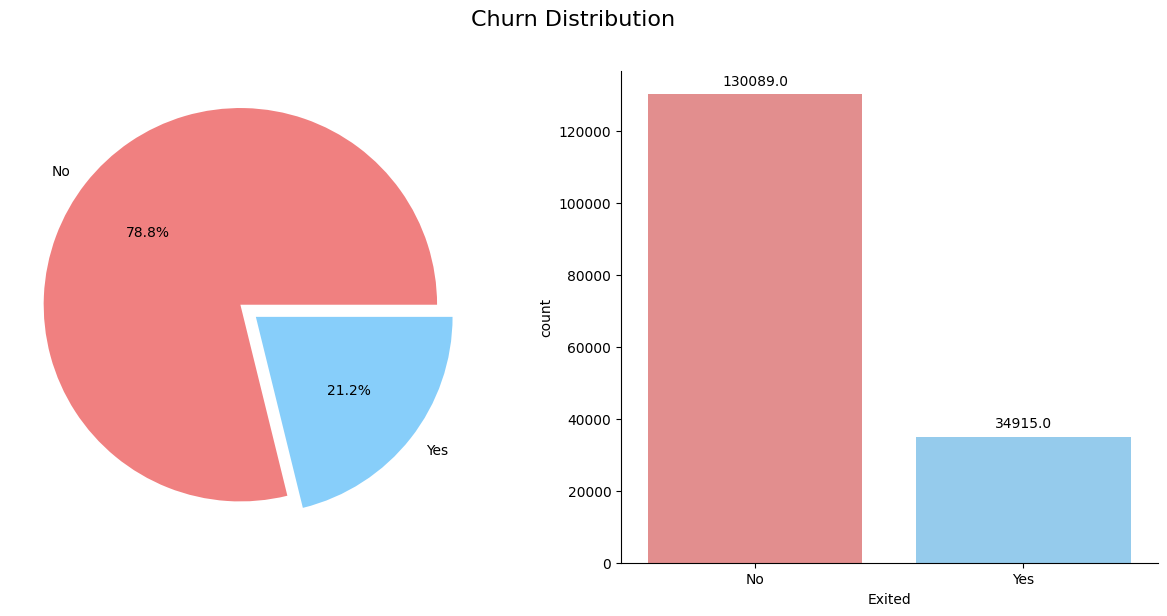

In [12]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6)) 
explode = (0.1, 0)
churn_counts = train['Exited'].value_counts()

axes[0].pie(churn_counts, labels=churn_counts.index, autopct='%1.1f%%', colors=['lightcoral', 'lightskyblue'], explode=explode)

sns.countplot(data=train, x='Exited', palette=['lightcoral', 'lightskyblue'], ax=axes[1])

for p in axes[1].patches:
    axes[1].annotate(f"{p.get_height()}", (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')

fig.suptitle("Churn Distribution", fontsize=16, y=1.02)

sns.despine(right=True, ax=axes[1])

plt.tight_layout()
plt.show()

### <p style="font-family:JetBrains Mono; font-weight:bold; letter-spacing: 2px; color:#C7B299; font-size:120%; text-align:left;padding: 0px; border-bottom: 3px solid #8B7D6B">Categorical</p>

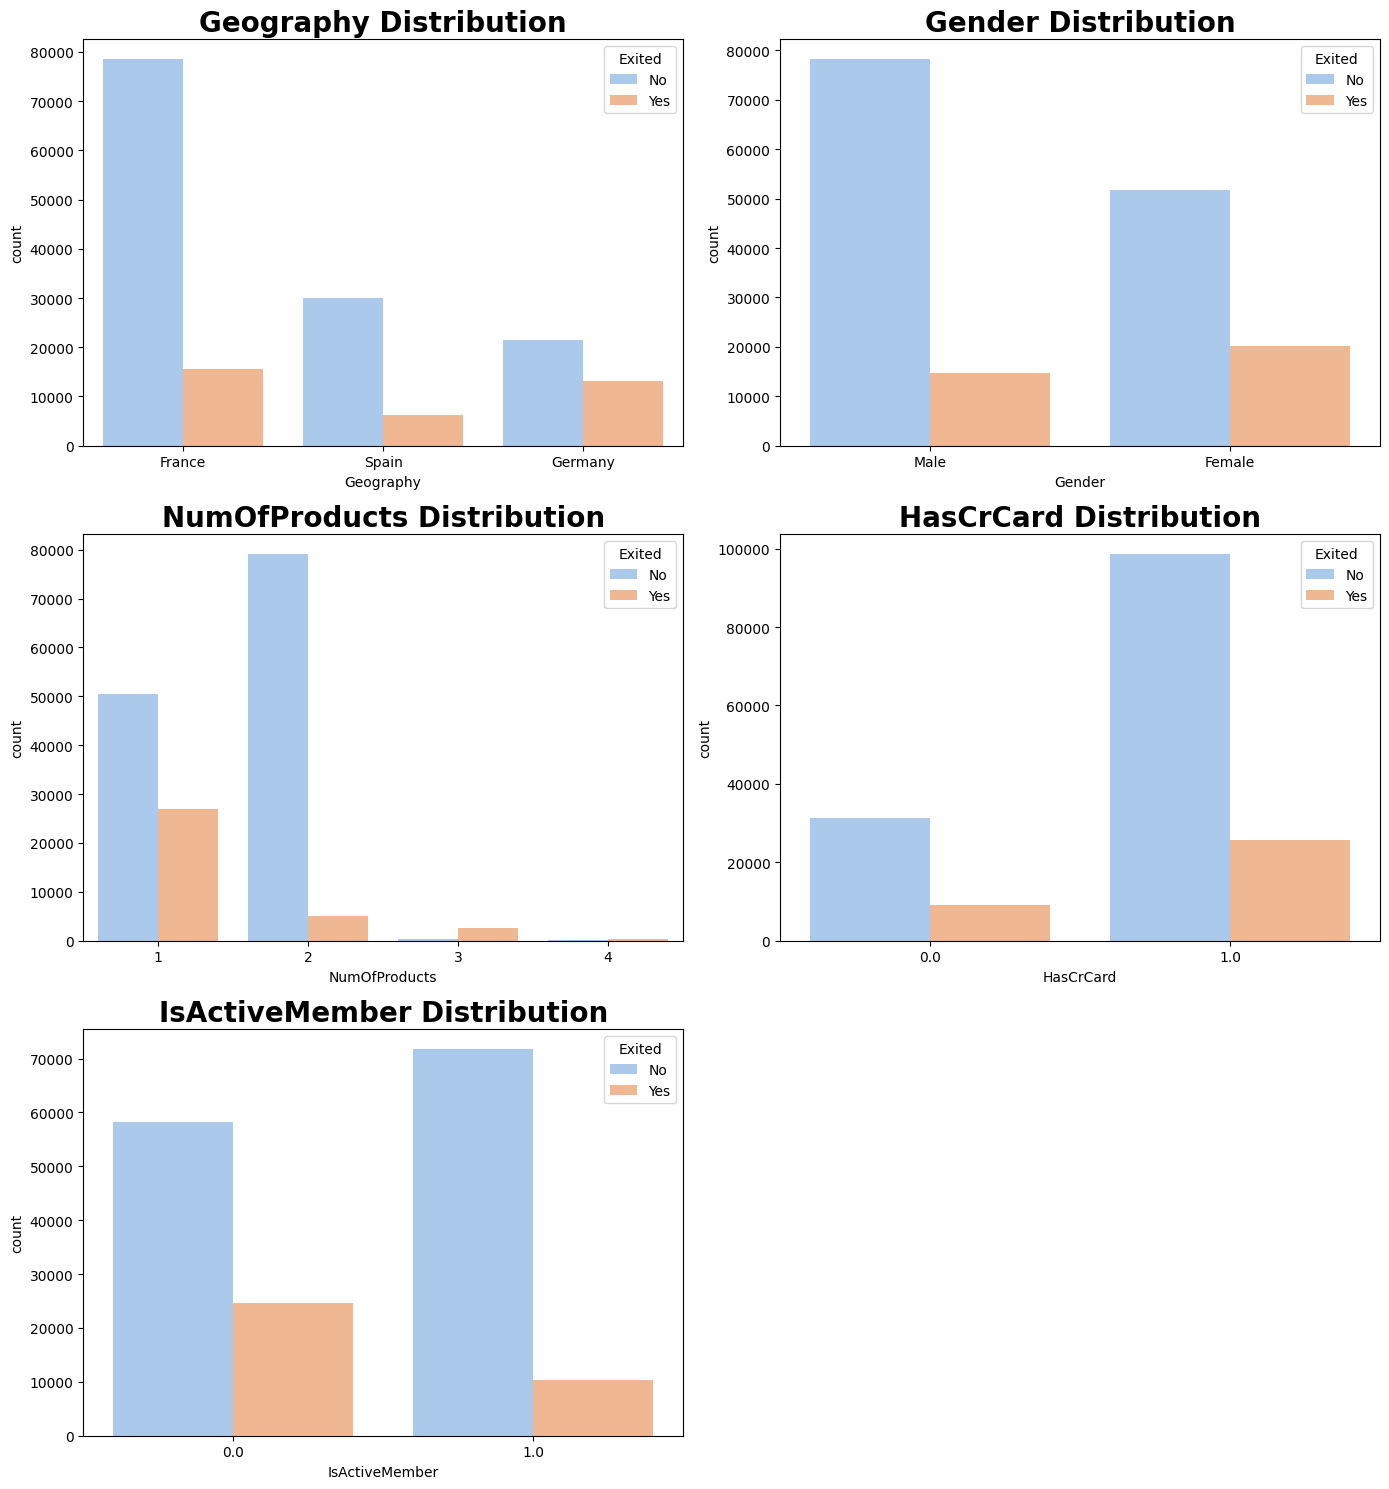

In [13]:
plt.figure(figsize=(14,len(cat_cols)*3))
for idx,column in enumerate(cat_cols):
    plt.subplot(len(cat_cols)//2+1,2,idx+1)
    sns.countplot(hue="Exited", x=column, data=train, palette="pastel")
    plt.title(f"{column} Distribution",weight='bold',fontsize=20)
    plt.tight_layout()

### <p style="font-family:JetBrains Mono; font-weight:bold; letter-spacing: 2px; color:#C7B299; font-size:120%; text-align:left;padding: 0px; border-bottom: 3px solid #8B7D6B">Numerical</p>

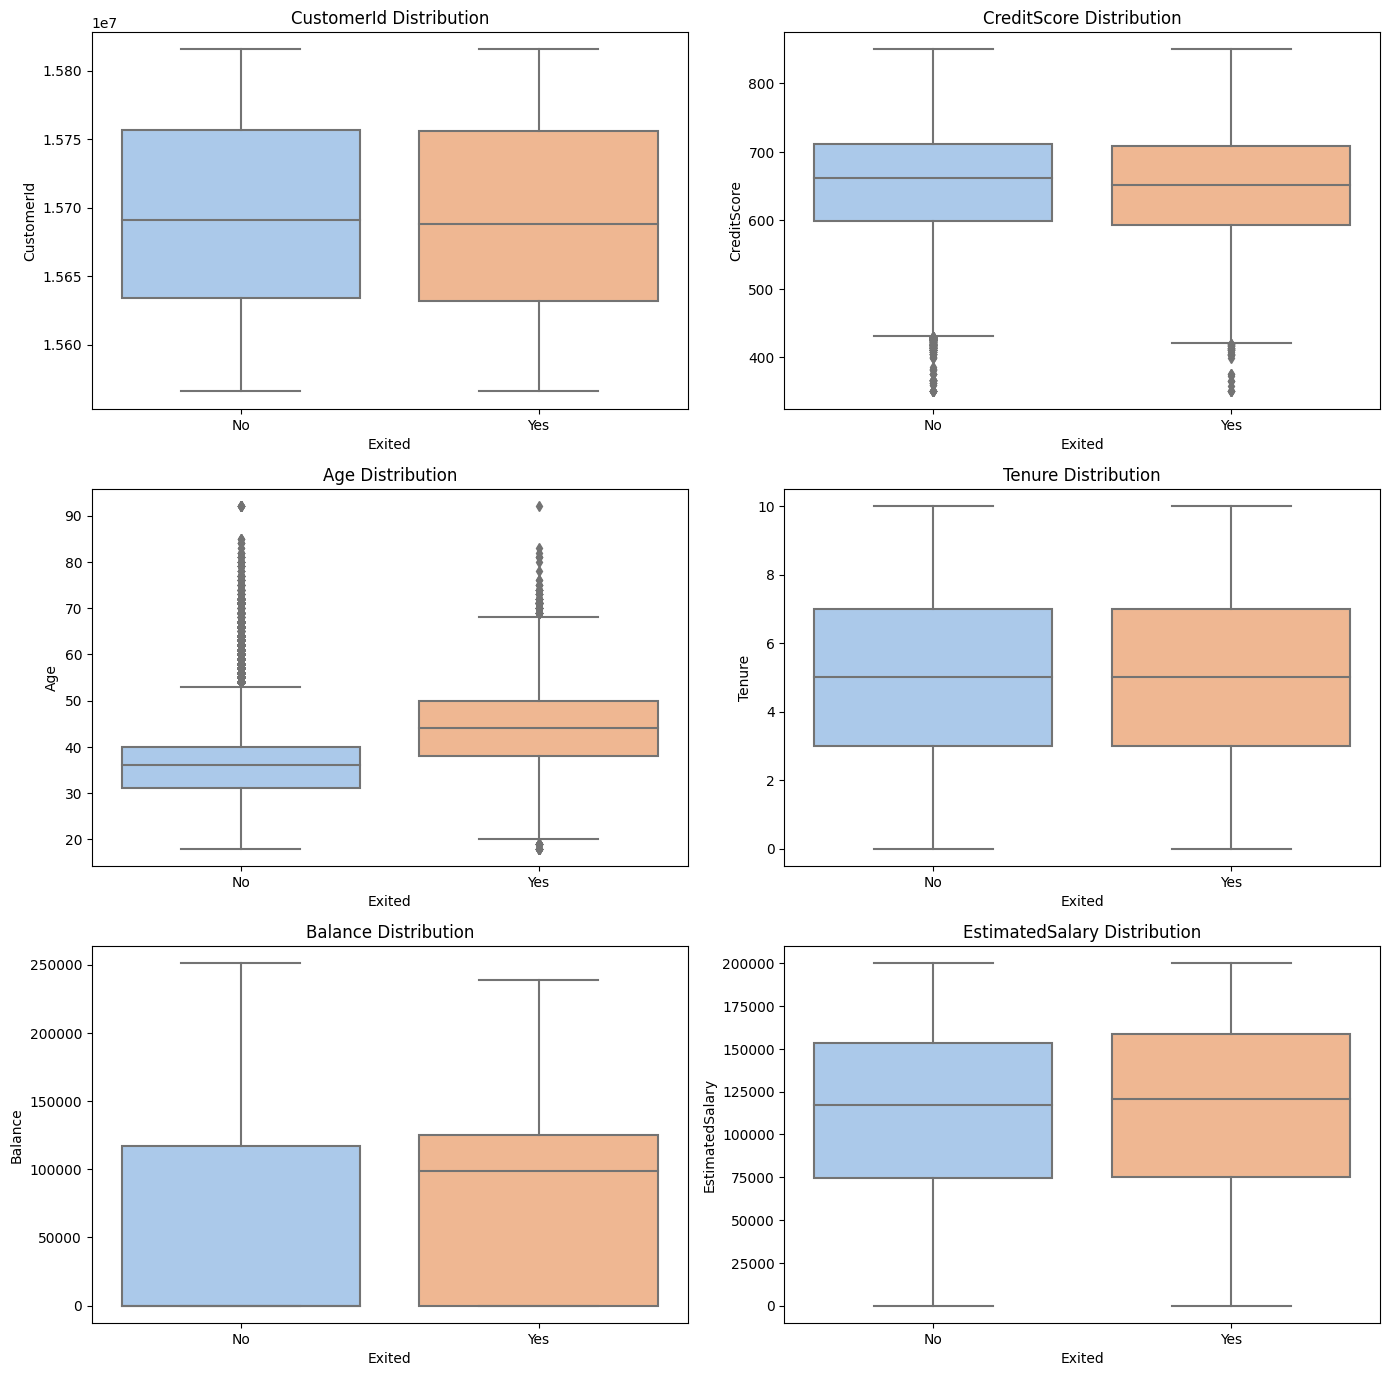

In [14]:
plt.figure(figsize=(14,len(num_cols)*3))
for idx,column in enumerate(num_cols):
    plt.subplot(len(num_cols)//2+1,2,idx+1)
    sns.boxplot(x="Exited", y=column, data=train,palette="pastel")
    plt.title(f"{column} Distribution")
    plt.tight_layout()

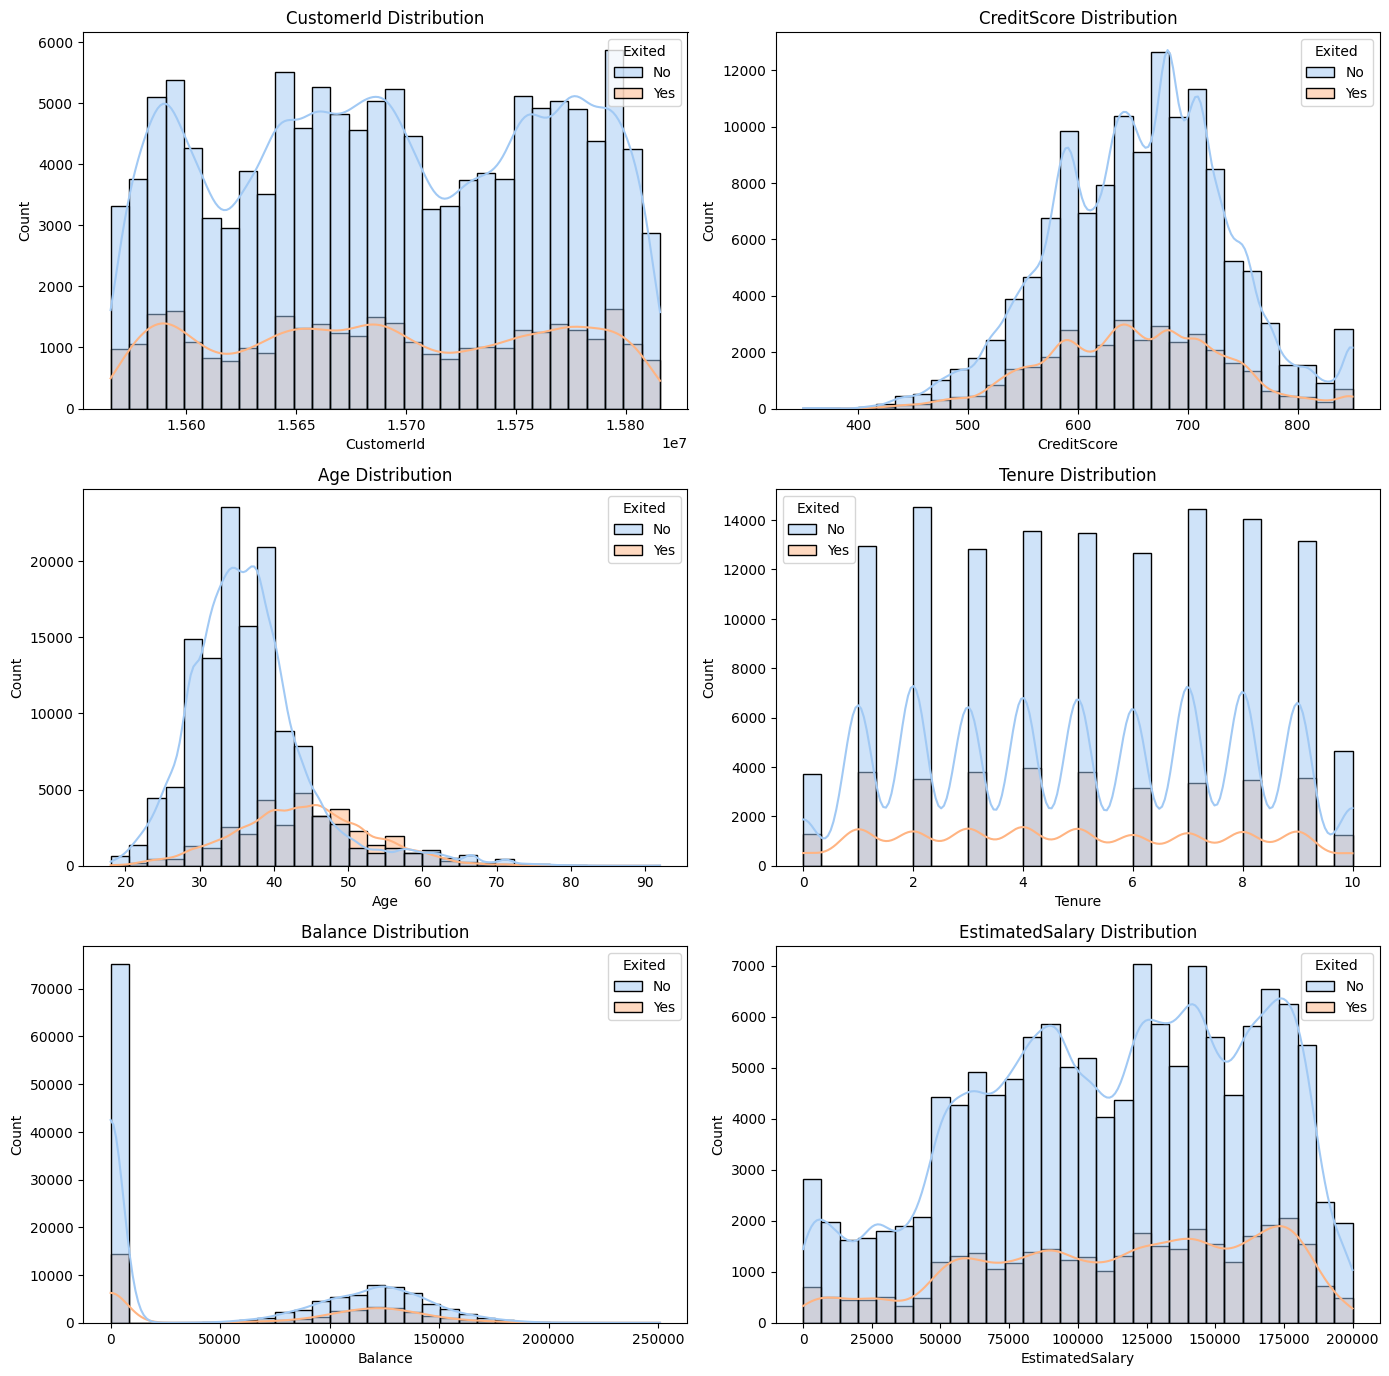

In [15]:
plt.figure(figsize=(14,len(num_cols)*3))
for idx,column in enumerate(num_cols):
    plt.subplot(len(num_cols)//2+1,2,idx+1)
    sns.histplot(x=column, hue="Exited", data=train,bins=30,kde=True, palette="pastel")
    plt.title(f"{column} Distribution")
    plt.tight_layout()

<p style="background-color:#C7B299; font-family:'Courier New', monospace;  font-size:140%; text-align:center; padding: 10px; border-radius: 20px;"> <b>🛠️ Feature Engineering 🛠️</b> </p>

In [16]:
train["Exited"]=train["Exited"].map({"No": 0,"Yes": 1})

In [17]:
train = pd.get_dummies(train, columns=cat_cols, drop_first = True)
test = pd.get_dummies(test, columns=cat_cols, drop_first = True)

<div style="border-radius:10px; border:#484366 solid; padding: 15px; background-color: #FFEBCC; font-size:100%; text-align:left">
    <b>New Features</b>


In [18]:
train['FinancialStability'] = train['CreditScore'] / train['EstimatedSalary']
train['TenureTimesAge'] = train['Tenure'] * train['Age']

test['FinancialStability'] = test['CreditScore'] / test['EstimatedSalary']
test['TenureTimesAge'] = test['Tenure'] * test['Age']

In [19]:
train.head()

,CustomerId,CreditScore,Age,Tenure,Balance,EstimatedSalary,Exited,Geography_Germany,Geography_Spain,Gender_Male,NumOfProducts_2,NumOfProducts_3,NumOfProducts_4,HasCrCard_1.0,IsActiveMember_1.0,FinancialStability,TenureTimesAge
0,15674932,668,33.0,3,0.00,181449.97,0,False,False,True,True,False,False,True,False,0.003681,99.0
1,15749177,627,33.0,1,0.00,49503.50,0,False,False,True,True,False,False,True,True,0.012666,33.0
2,15694510,678,40.0,10,0.00,184866.69,0,False,False,True,True,False,False,True,False,0.003668,400.0
3,15741417,581,34.0,2,148882.54,84560.88,0,False,False,True,False,False,False,True,True,0.006871,68.0
4,15766172,716,33.0,5,0.00,15068.83,0,False,True,True,True,False,False,True,True,0.047515,165.0


<p style="background-color:#C7B299; font-family:'Courier New', monospace;  font-size:140%; text-align:center; padding: 10px; border-radius: 20px;"> <b>🛠️ Modeling 🤖</b> </p>

### <p style="font-family:JetBrains Mono; font-weight:bold; letter-spacing: 2px; color:#C7B299; font-size:120%; text-align:left;padding: 0px; border-bottom: 3px solid #8B7D6B">Split</p>

In [20]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
X = train.drop("Exited", axis=1)
y = train["Exited"]


X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.1, random_state = 101)

### <p style="font-family:JetBrains Mono; font-weight:bold; letter-spacing: 2px; color:#C7B299; font-size:120%; text-align:left;padding: 0px; border-bottom: 3px solid #8B7D6B">Feature Importance</p>

0.8859184078445341

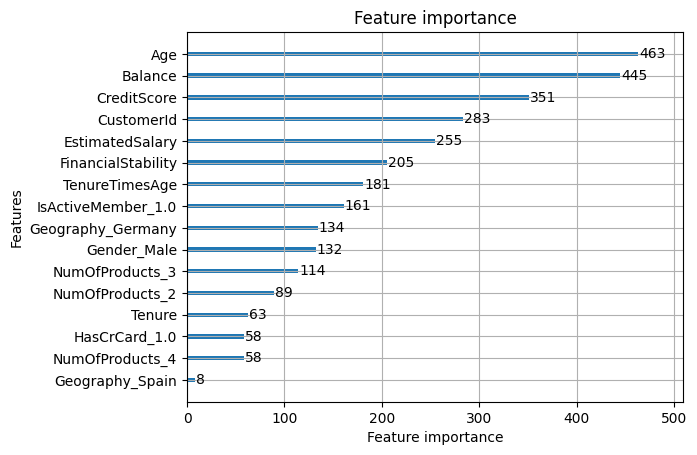

In [21]:
import lightgbm
lgb = lightgbm.LGBMClassifier(metric = "auc")
lgb.fit(X_train, y_train)
lightgbm.plot_importance(lgb);
roc_auc_score(y_test,lgb.predict_proba(X_test)[:,1])

0.8836389840477574

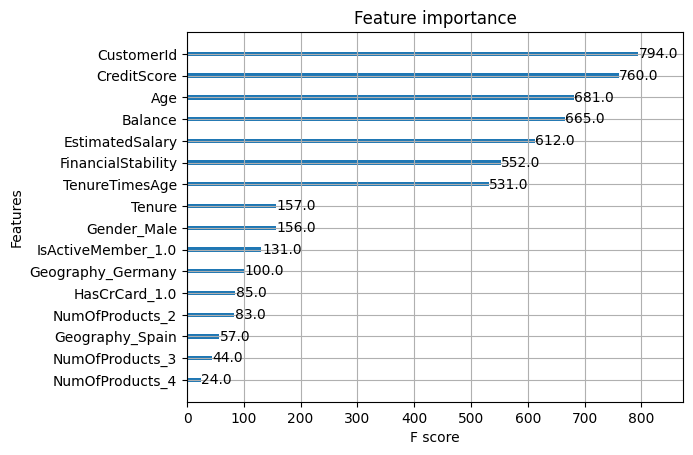

In [22]:
import xgboost
xgb = xgboost.XGBClassifier(eval_metric="auc")
xgb.fit(X_train, y_train)
xgboost.plot_importance(xgb);
roc_auc_score(y_test,xgb.predict_proba(X_test)[:,1])

### <p style="font-family:JetBrains Mono; font-weight:bold; letter-spacing: 2px; color:#C7B299; font-size:120%; text-align:left;padding: 0px; border-bottom: 3px solid #8B7D6B">LightGBM Classifier</p>

In [23]:
from lightgbm import LGBMClassifier

def objective_lgb(trial):
    
    lgb_params = {
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 1.0),
        'max_depth': trial.suggest_int('max_depth', 3, 20),
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.1, 1.0),

    }

    model = LGBMClassifier(**lgb_params)
    model.fit(X_train, y_train)
    y_pred = model.predict_proba(X_test)[:, 1]
    roc_auc = roc_auc_score(y_test, y_pred)

    return roc_auc

In [24]:
study_lgb = optuna.create_study(direction='maximize')
optuna.logging.set_verbosity(optuna.logging.WARNING)
study_lgb.optimize(objective_lgb, n_trials=50,show_progress_bar=True)

[I 2024-01-23 11:32:37,172] A new study created in memory with name: no-name-03d4ee64-37e6-4b0e-ae37-7aa0f141b2c2


  0%|          | 0/50 [00:00<?, ?it/s]

In [25]:
print('Best parameters', study_lgb.best_params)

Best parameters {'learning_rate': 0.031506785859445455, 'max_depth': 14, 'n_estimators': 943, 'colsample_bytree': 0.7425228120597543}


In [26]:
lgbm_final = LGBMClassifier(**study_lgb.best_params)
lgbm_final.fit(X_train, y_train)
y_pred = lgbm_final.predict_proba(X_test)[:,1]

print('Accuracy: ', roc_auc_score(y_test, y_pred))

Accuracy:  0.8869490474411422


### <p style="font-family:JetBrains Mono; font-weight:bold; letter-spacing: 2px; color:#C7B299; font-size:120%; text-align:left;padding: 0px; border-bottom: 3px solid #8B7D6B">XGBoost Classifier</p>

In [27]:
from xgboost import XGBClassifier

def objective_xgb(trial):
    
    xgb_params = {
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 1.0),
        'max_depth': trial.suggest_int('max_depth', 3, 20),
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.1, 1.0)
    }

    model = XGBClassifier(**xgb_params)

    model.fit(X_train, y_train)

    y_pred = model.predict_proba(X_test)[:, 1]
    roc_auc = roc_auc_score(y_test, y_pred)

    return roc_auc

In [28]:
study_xgb = optuna.create_study(direction='maximize')
optuna.logging.set_verbosity(optuna.logging.WARNING)
study_xgb.optimize(objective_xgb, n_trials=50,show_progress_bar=True)

  0%|          | 0/50 [00:00<?, ?it/s]

In [29]:
print('Best parameters', study_xgb.best_params)

Best parameters {'learning_rate': 0.07356409102959374, 'max_depth': 3, 'n_estimators': 917, 'colsample_bytree': 0.42513664606815627}


In [30]:
xgb_final = XGBClassifier(**study_xgb.best_params)
xgb_final.fit(X_train, y_train)
y_pred = xgb_final.predict_proba(X_test)[:,1]

print('Accuracy: ', roc_auc_score(y_test, y_pred))

Accuracy:  0.8871704838314749


### <p style="font-family:JetBrains Mono; font-weight:bold; letter-spacing: 2px; color:#C7B299; font-size:120%; text-align:left;padding: 0px; border-bottom: 3px solid #8B7D6B">Voting Classifier</p>

In [31]:
from sklearn.ensemble import VotingClassifier
voting = VotingClassifier(estimators=[
                                      ('lgbm', lgbm_final), 
                                      ('xgb', xgb_final)], voting='soft')
voting.fit(X_train,y_train)
voting_pred = voting.predict_proba(X_test)[:,1]

print('Accuracy: ', roc_auc_score(y_test, voting_pred))

Accuracy:  0.8875250325421384


<p style="background-color:#C7B299; font-family:'Courier New', monospace;  font-size:140%; text-align:center; padding: 10px; border-radius: 20px;"> <b>🕵️‍ Prediction 🔮</b> </p>

In [32]:
sub["Exited"]=voting.predict_proba(test)[:, 1]
sub.to_csv('submission.csv',index=False)
sub

,id,Exited
0,165034,0.023242
1,165035,0.803234
2,165036,0.020545
3,165037,0.207052
4,165038,0.371451
...,...,...
110018,275052,0.035302
110019,275053,0.100461
110020,275054,0.020963
110021,275055,0.151504
